In [1]:
import tensorflow as tf
print(tf.__version__)

physical_devices = tf.config.experimental.list_physical_devices('GPU')
for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, True)
    

2.3.1


# Model subclassing and custom training loops

 ## Coding tutorials
 #### [1. Model subclassing](#coding_tutorial_1)
 #### [2. Custom layers](#coding_tutorial_2)
 #### [3. Automatic differentiation](#coding_tutorial_3)
 #### [4. Custom training loops](#coding_tutorial_4)
 #### [5. tf.function decorator](#coding_tutorial_5)

***
<a id="coding_tutorial_1"></a>
## Model subclassing

In [2]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Softmax, concatenate, Conv2D, Flatten

#### Create a simple model using the model subclassing API

In [5]:
# Build the model

class MyModel(Model):
    def __init__(self):
        super(MyModel, self).__init__()
        self.conv1 = Conv2D(32, 3, activation='relu')
        self.flatten = Flatten()
        self.d1 = Dense(128, activation='relu')
        self.d2 = Dense(10)
        self.d3 = Dense(5)
        self.softmax = Softmax()
        self.dropout = Dropout(0.4)

    def call(self, x, training=True):
        print(x.shape)
        x = self.conv1(x)
        x = self.flatten(x)
        x = self.d1(x)
        if training:
            x = self.dropout(x)   
        y2 = self.d2(x)
        y3 = self.d3(x)
        concat = concatenate([x, y2])        
        return self.softmax(concat)

In [6]:
# Print the model summary

model = MyModel()
model(tf.random.uniform([1, 10, 10, 3]))
model.summary()

(1, 10, 10, 3)
Model: "my_model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  896       
_________________________________________________________________
flatten (Flatten)            multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  262272    
_________________________________________________________________
dense_1 (Dense)              multiple                  1290      
_________________________________________________________________
dense_2 (Dense)              multiple                  645       
_________________________________________________________________
softmax (Softmax)            multiple                  0         
_________________________________________________________________
dropout (Dropout)            multiple    

***
<a id="coding_tutorial_2"></a>
## Custom layers

In [7]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Softmax

#### Create custom layers

In [9]:
# Create a custom layer
class MyLayer(Layer):
    
    def __init__(self, units, input_dim):
        super(MyLayer, self).__init__()
        self.w = self.add_weight(shape=(input_dim, units), initializer='random_normal')
        self.b = self.add_weight(shape=(units, ), initializer='zeros')
        
    def call(self, inputs):
        return tf.matmul(inputs, self.w) + self.b
    
    
dense_layer = MyLayer(3, 5)
x = tf.ones((1, 5))
print(dense_layer(x))
print(dense_layer.weights)

print('trainable weights:', len(dense_layer.trainable_weights))
print('non-trainable weights:', len(dense_layer.non_trainable_weights))

tf.Tensor([[ 0.03125742 -0.01908827  0.0408942 ]], shape=(1, 3), dtype=float32)
[<tf.Variable 'Variable:0' shape=(5, 3) dtype=float32, numpy=
array([[ 0.03143116, -0.01387817, -0.00489386],
       [ 0.00372909,  0.02722758, -0.06808974],
       [-0.02975311, -0.02390136,  0.00197904],
       [ 0.05841005,  0.02288632,  0.04973319],
       [-0.03255976, -0.03142264,  0.06216556]], dtype=float32)>, <tf.Variable 'Variable:0' shape=(3,) dtype=float32, numpy=array([0., 0., 0.], dtype=float32)>]
trainable weights: 2
non-trainable weights: 0


In [13]:
# Specify trainable weights

class MyLayer(Layer):
    
    def __init__(self, units, input_dim):
        super(MyLayer, self).__init__()
        self.w = self.add_weight(shape=(input_dim, units), initializer='random_normal', trainable=False)
        self.b = self.add_weight(shape=(units, ), initializer='zeros', trainable=False)
        
    def call(self, inputs):
        return tf.matmul(inputs, self.w) + self.b
    
    
dense_layer = MyLayer(3, 5)
x = tf.ones((1, 5))
print(dense_layer(x))
print(dense_layer.weights)

tf.Tensor([[-0.06790688 -0.12528013  0.0152339 ]], shape=(1, 3), dtype=float32)
[<tf.Variable 'Variable:0' shape=(5, 3) dtype=float32, numpy=
array([[ 0.03081371,  0.00927037, -0.02496572],
       [ 0.00773558, -0.04709209, -0.00690248],
       [ 0.01886951, -0.0501463 ,  0.006316  ],
       [-0.05843503,  0.0138992 , -0.01348895],
       [-0.06689064, -0.0512113 ,  0.05427506]], dtype=float32)>, <tf.Variable 'Variable:0' shape=(3,) dtype=float32, numpy=array([0., 0., 0.], dtype=float32)>]


In [14]:
print('trainable weights:', len(dense_layer.trainable_weights))
print('non-trainable weights:', len(dense_layer.non_trainable_weights))

trainable weights: 0
non-trainable weights: 2


In [15]:
# Create a custom layer to accumulate means of output values

class MyLayerMean(Layer):
    
    def __init__(self, units, input_dim):
        super(MyLayerMean, self).__init__()
        self.w = self.add_weight(shape=(input_dim, units), initializer='random_normal')
        self.b = self.add_weight(shape=(units, ), initializer='zeros')
        self.sum_activation = tf.Variable(initial_value=tf.zeros(units, ), trainable=False)
        self.number_call = tf.Variable(initial_value = 0, trainable=False)
        
    def call(self, inputs):
        activations = tf.matmul(inputs, self.w) + self.b
        self.sum_activation.assign_add(tf.reduce_sum(activations, axis=0))
        self.number_call.assign_add(inputs.shape[0])
        return activations, self.sum_activation/tf.cast(self.number_call, tf.float32)
    
    
dense_layer = MyLayerMean(3, 5)


In [16]:
# Test the layer

y, activation_means = dense_layer(tf.ones((1, 5)))
print(activation_means.numpy())
print(y.numpy())

[ 0.06718661  0.03488144 -0.01790604]
[[ 0.06718661  0.03488144 -0.01790604]]


In [17]:
# Create a Dropout layer as a custom layer

class MyDropout(Layer):

    def __init__(self, rate):
        super(MyDropout, self).__init__()
        self.rate = rate
        
    def call(self, inputs):
        # Define forward pass for dropout layer
        return tf.nn.dropout(inputs, rate=self.rate)

#### Implement the custom layers into a model

In [18]:
# Build the model using custom layers with the model subclassing API

class MyModel(Model):

    def __init__(self, units_1, input_dim_1, units_2, units_3):
        super(MyModel, self).__init__()
        # Define layers
        self.layer_1 = MyLayer(units_1, input_dim_1)
        self.dropout_1 = MyDropout(0.5)
        self.layer_2 = MyLayer(units_2, units_1)
        self.dropout_2 = MyDropout(0.5)
        self.layer_3 = MyLayer(units_3, units_2)
        self.softmax = Softmax()
           
    def call(self, inputs):
        # Define forward pass
        x = self.layer_1(inputs)
        x = tf.nn.relu(x)
        x = self.dropout_1(x)
        x = self.layer_2(x)
        x = tf.nn.relu(x)
        
        x = self.dropout_2(x)    
        x = self.layer_3(x)        
        return self.softmax(x)

In [19]:
# Instantiate a model object

model = MyModel(64,10000,64,46)
print(model(tf.ones((1, 10000))))
model.summary()

tf.Tensor(
[[0.02586911 0.02680089 0.00743933 0.04216158 0.020398   0.01929061
  0.01589965 0.00798797 0.01666108 0.01877224 0.08748534 0.02643179
  0.01344579 0.03458112 0.00992345 0.02410643 0.00680737 0.00844778
  0.047025   0.02011336 0.00922797 0.00703684 0.01476552 0.01113919
  0.01539689 0.02179172 0.01809353 0.02883304 0.01467332 0.01719328
  0.02829422 0.02822709 0.0086682  0.01580723 0.0208005  0.04827384
  0.02507771 0.030874   0.02659619 0.02047309 0.01913288 0.00965491
  0.00893363 0.02203197 0.01140189 0.03795335]], shape=(1, 46), dtype=float32)
Model: "my_model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
my_layer_4 (MyLayer)         multiple                  640064    
_________________________________________________________________
my_dropout (MyDropout)       multiple                  0         
_________________________________________________________________
my_layer_5 (MyLaye

In [20]:
tf.keras.utils.plot_model(model, '{}.png'.format(model.name), show_shapes=True) 

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


***
<a id="coding_tutorial_3"></a>
## Automatic differentiation

In [22]:
import numpy as np
import matplotlib.pyplot as plt

#### Create synthetic data

(20, 1) (20,)
tf.Tensor(
[[0.32146144]
 [0.46680474]
 [0.3501991 ]
 [0.24189818]
 [0.30318308]
 [0.40460992]
 [0.21030092]
 [0.60557365]
 [0.4752897 ]
 [0.4856081 ]
 [0.2718066 ]
 [0.7573285 ]
 [0.2264272 ]
 [0.5163777 ]
 [0.38000822]
 [0.48394656]
 [0.3472885 ]
 [0.3815558 ]
 [0.21271408]
 [0.01868033]], shape=(20, 1), dtype=float32)
tf.Tensor(
[2.3748071 2.537511  2.3614497 2.1059463 2.3620317 2.3943257 2.1459112
 2.6164172 2.3981912 2.5973115 2.2270236 2.6792178 2.3264687 2.4175737
 2.4736295 2.49313   2.2929692 2.3191407 2.0030274 2.028952 ], shape=(20,), dtype=float32)


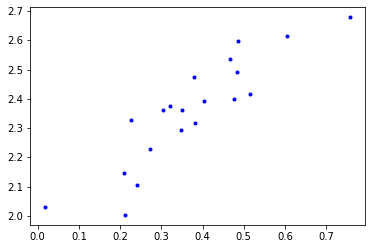

In [23]:
# Create data from a noise contaminated linear model

def MakeNoisyData(m, b, n=20):
    x = tf.random.uniform(shape=(n,))
    noise = tf.random.normal(shape=(len(x),), stddev=0.1)
    y = m * x + b + noise
    return x, y

m=1
b=2
x_train, y_train = MakeNoisyData(m,b)
x_train = tf.expand_dims(x_train, -1)
plt.plot(x_train, y_train, 'b.')
print(x_train.shape, y_train.shape)
print(x_train)
print(y_train)

#### Define a linear regression model

In [24]:
from tensorflow.keras.layers import Layer

In [25]:
# Build a custom layer for the linear regression model

class LinearLayer(Layer):

    def __init__(self, units, **kwargs):
        super(LinearLayer, self).__init__(**kwargs)
        self.units = units
    
    def build(self, input_shape):
        self.w = self.add_weight(shape=(input_shape[-1], self.units),
                                 initializer='random_normal')
        self.b = self.add_weight(shape=(self.units,),
                                 initializer='zeros')
    def call(self, inputs):
        return tf.matmul(inputs, self.w)+self.b
    
linear_regression = LinearLayer(1)

#### Define the loss function

In [26]:
# Define the mean squared error loss function

def SquaredError(y_pred, y_true):
#     print(y_pred.shape, y_true.shape)
    return tf.reduce_mean(tf.square(tf.squeeze(y_pred) - y_true)) 



starting_loss = SquaredError(linear_regression(x_train), y_train)
print("Starting loss", starting_loss.numpy())

for variables in linear_regression.trainable_variables:
    print('-'*50)
    print(variables)

Starting loss 5.652242
--------------------------------------------------
<tf.Variable 'linear_layer/Variable:0' shape=(1, 1) dtype=float32, numpy=array([[-0.03304827]], dtype=float32)>
--------------------------------------------------
<tf.Variable 'linear_layer/Variable:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>


#### Train and plot the model

In [27]:
# Implement a gradient descent training loop for the linear regression model

learning_rate = 0.05
steps =25

for i in range(steps):
    with tf.GradientTape() as tape:
        precisions = linear_regression(x_train)
        loss = SquaredError(precisions, y_train)
        
    gradients = tape.gradient(loss, linear_regression.trainable_variables)
    linear_regression.w.assign_sub(learning_rate * gradients[0])
    linear_regression.b.assign_sub(learning_rate * gradients[1])
    
    print('step {}, loss {:0.5f}, w {}, b {}'.format(i+1, loss, 
                                                     linear_regression.w.numpy()[0][0], 
                                                     linear_regression.b.numpy()[0]))
        

step 1, loss 5.65224, w 0.05803130194544792, b 0.23700805008411407
step 2, loss 4.43652, w 0.13877257704734802, b 0.4469175338745117
step 3, loss 3.48267, w 0.21035636961460114, b 0.6328240036964417
step 4, loss 2.73430, w 0.27382856607437134, b 0.7974693775177002
step 5, loss 2.14713, w 0.3301156461238861, b 0.9432823657989502
step 6, loss 1.68644, w 0.38003820180892944, b 1.0724142789840698
step 7, loss 1.32499, w 0.4243231415748596, b 1.1867705583572388
step 8, loss 1.04140, w 0.463614284992218, b 1.288039207458496
step 9, loss 0.81889, w 0.4984819293022156, b 1.3777152299880981
step 10, loss 0.64431, w 0.5294312238693237, b 1.457122802734375
step 11, loss 0.50734, w 0.5569096207618713, b 1.527435064315796
step 12, loss 0.39987, w 0.5813134908676147, b 1.5896910429000854
step 13, loss 0.31555, w 0.6029938459396362, b 1.6448110342025757
step 14, loss 0.24940, w 0.6222617030143738, b 1.6936101913452148
step 15, loss 0.19749, w 0.6393924951553345, b 1.7368106842041016
step 16, loss 0.1

w:1,  trained w:[[0.992085]]
b:2,  trained b:[1.9148035]
[0.00823128 0.02790162 0.04757196 0.0672423  0.08691263 0.10658297
 0.12625331 0.14592365 0.16559399 0.18526432 0.20493466 0.224605
 0.24427534 0.26394568 0.28361601 0.30328635 0.32295669 0.34262703
 0.36229737 0.38196771 0.40163804 0.42130838 0.44097872 0.46064906
 0.4803194  0.49998973 0.51966007 0.53933041 0.55900075 0.57867109
 0.59834142 0.61801176 0.6376821  0.65735244 0.67702278 0.69669311
 0.71636345 0.73603379 0.75570413 0.77537447 0.7950448  0.81471514
 0.83438548 0.85405582 0.87372616 0.89339649 0.91306683 0.93273717
 0.95240751 0.97207785]
[1.9229696 1.9424843 1.9619989 1.9815136 2.0010283 2.0205429 2.0400574
 2.0595722 2.0790868 2.0986013 2.1181161 2.1376307 2.1571455 2.17666
 2.1961746 2.2156894 2.235204  2.2547185 2.2742333 2.293748  2.3132625
 2.3327773 2.3522918 2.3718066 2.3913212 2.4108357 2.4303503 2.449865
 2.4693797 2.4888945 2.508409  2.5279236 2.5474384 2.566953  2.5864677
 2.6059823 2.6254969 2.6450117 2.

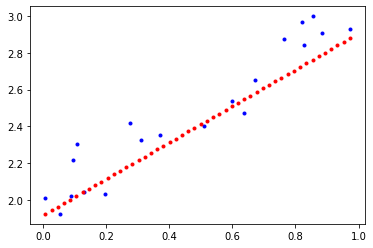

In [58]:
# Plot the learned regression model

print("w:{},  trained w:{}".format(m, linear_regression.w.numpy()))
print("b:{},  trained b:{}".format(b, linear_regression.b.numpy()))

x_train_flatten = tf.squeeze(x_train)

plt.plot(x_train_flatten, y_train, 'b.')

x_linear_regression = np.linspace(min(x_train_flatten), max(x_train_flatten),50)
print(x_linear_regression)
y_linear_regression = tf.squeeze(np.expand_dims(x_linear_regression, -1) @ linear_regression.w +linear_regression.b).numpy()
print(y_linear_regression)

plt.plot(x_linear_regression, y_linear_regression, 'r.')

***
<a id="coding_tutorial_4"></a>
## Custom training loops

In [59]:
import numpy as np
import matplotlib.pyplot as plt
import time

#### Build the model

In [60]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Softmax

In [61]:
# Define the custom layers and model

class MyLayer(Layer):

    def __init__(self, units, **kwargs):
        super(MyLayer, self).__init__(**kwargs)
        self.units = units
    
    def build(self, input_shape):
        self.w = self.add_weight(shape=(input_shape[-1], self.units),
                                 initializer='random_normal', 
                                 name='kernal'
                                )
        self.b = self.add_weight(shape=(self.units,),
                                 initializer='zeros',
                                 name='bias'
                                )
    def call(self, inputs):
        return tf.matmul(inputs, self.w)+self.b
    
class MyDropout(Layer):

    def __init__(self, rate):
        super(MyDropout, self).__init__()
        self.rate = rate
        
    def call(self, inputs, training=None):
        # Define forward pass for dropout layer
        if training:
            return tf.nn.dropout(inputs, rate=self.rate)
        return inputs
    
class MyModel(Model):

    def __init__(self, units_1, units_2, units_3):
        super(MyModel, self).__init__()
        # Define layers
        self.layer_1 = MyLayer(units_1)
        self.dropout_1 = MyDropout(0.5)
        self.layer_2 = MyLayer(units_2)
        self.dropout_2 = MyDropout(0.5)
        self.layer_3 = MyLayer(units_3)
        self.softmax = Softmax()
           
    def call(self, inputs, training=True):
        # Define forward pass
        x = self.layer_1(inputs)
        x = tf.nn.relu(x)
        x = self.dropout_1(x, training)
        x = self.layer_2(x)
        x = tf.nn.relu(x)   
        x = self.dropout_2(x, training)    
        x = self.layer_3(x)        
        return self.softmax(x)
    
model = MyModel(64, 64, 46)
print(model(tf.ones((1, 10000))))
model.summary()

tf.Tensor(
[[0.05592446 0.02912387 0.05483283 0.0134755  0.02898099 0.00849919
  0.01115417 0.00734725 0.02762586 0.00734801 0.01108708 0.01038402
  0.01077607 0.02275424 0.00715126 0.03759286 0.04782124 0.02599177
  0.00428034 0.00763563 0.00977654 0.02093908 0.02683081 0.00584217
  0.02607915 0.01004475 0.00944989 0.01612506 0.00350854 0.01468987
  0.00519703 0.00797115 0.00821024 0.02048633 0.04351611 0.00471149
  0.00842408 0.0337284  0.05889039 0.00838686 0.02847678 0.0509199
  0.01472512 0.01737863 0.00774345 0.10816149]], shape=(1, 46), dtype=float32)
Model: "my_model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
my_layer_13 (MyLayer)        multiple                  640064    
_________________________________________________________________
my_dropout_6 (MyDropout)     multiple                  0         
_________________________________________________________________
my_layer_14 (MyLaye

#### Load the reuters dataset and define the class_names 

In [62]:
# Load the dataset

from tensorflow.keras.datasets import reuters

(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

class_names = ['cocoa','grain','veg-oil','earn','acq','wheat','copper','housing','money-supply',
   'coffee','sugar','trade','reserves','ship','cotton','carcass','crude','nat-gas',
   'cpi','money-fx','interest','gnp','meal-feed','alum','oilseed','gold','tin',
   'strategic-metal','livestock','retail','ipi','iron-steel','rubber','heat','jobs',
   'lei','bop','zinc','orange','pet-chem','dlr','gas','silver','wpi','hog','lead']

print(len(class_names))

46


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/datasets/reuters.py:148: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/datasets/reuters.py:149: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


In [63]:
print(train_data.shape, train_labels.shape)
print(test_data.shape, test_labels.shape)

print(train_data[0], len(train_data[0]))

(8982,) (8982,)
(2246,) (2246,)
[1, 2, 2, 8, 43, 10, 447, 5, 25, 207, 270, 5, 3095, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 4579, 1005, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 1245, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12] 87


In [64]:
# Print the class of the f·irst sample

print("Label: {}".format(class_names[train_labels[0]]))

Label: earn


#### Get the dataset word index

In [65]:
# Load the Reuters word index

word_to_index = reuters.get_word_index()

invert_word_index = dict([(value, key) for (key, value) in word_to_index.items()])
text_news = ' '.join([invert_word_index.get(i - 3, '?') for i in train_data[0]])

In [66]:
# Print the first data example sentence
print(text_news)
' '.join([invert_word_index.get(i - 3, '?') for i in train_data[0]])

? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3


'? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3'

#### Preprocess the data

In [67]:
# Define a function that encodes the data into a 'bag of words' representation

def bag_of_words(text_samples, elements=10000):
    output = np.zeros((len(text_samples), elements))
    for i, word in enumerate(text_samples):
        if i==0: print(word)
        output[i, word] = 1.
    return output

x_train = bag_of_words(train_data)
x_test = bag_of_words(test_data)

print("Shape of x_train:", x_train.shape)
print("Shape of x_test:", x_test.shape)
print(x_train.dtype)

[1, 2, 2, 8, 43, 10, 447, 5, 25, 207, 270, 5, 3095, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 4579, 1005, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 1245, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12]
[1, 4, 1378, 2025, 9, 697, 4622, 111, 8, 25, 109, 29, 3650, 11, 150, 244, 364, 33, 30, 30, 1398, 333, 6, 2, 159, 9, 1084, 363, 13, 2, 71, 9, 2, 71, 117, 4, 225, 78, 206, 10, 9, 1214, 8, 4, 270, 5, 2, 7, 748, 48, 9, 2, 7, 207, 1451, 966, 1864, 793, 97, 133, 336, 7, 4, 493, 98, 273, 104, 284, 25, 39, 338, 22, 905, 220, 3465, 644, 59, 20, 6, 119, 61, 11, 15, 58, 579, 26, 10, 67, 7, 4, 738, 98, 43, 88, 333, 722, 12, 20, 6, 19, 746, 35, 15, 10, 9, 1214, 855, 129, 783, 21, 4, 2280, 244, 364, 51, 16, 299, 452, 16, 515, 4, 99, 29, 5, 4, 364, 281, 48, 10, 9, 1214, 23, 644, 47, 20, 324, 27, 56, 2, 2, 5, 192, 510, 17, 12]
Shape of x_train: (898

In [68]:
print(len([str(i) for i,v in enumerate(x_train[0]) if v>0] ))

57


In [69]:
print(train_data[0], len(train_data[0]), len(set(train_data[0])))
print(train_data.shape)

[1, 2, 2, 8, 43, 10, 447, 5, 25, 207, 270, 5, 3095, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 4579, 1005, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 1245, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12] 87 57
(8982,)


#### Define the loss function and optimizer



In [70]:
# Define the categorical cross entropy loss and Adam optimizer

loss_object = tf.keras.losses.SparseCategoricalCrossentropy()

def loss(model, x, y, wd):
    kernel_variables = []
    for l in model.layers:
        for w in l.weights:
            if 'kernel' in w.name:
                kernel_variables.append(w)
    wd_penalty = wd * tf.reduce_sum([tf.reduce_sum(tf.square(k)) for k in kernel_variables])
    y_ = model(x)
    total_loss = loss_object(y_true=y, y_pred=y_) + wd_penalty
    return total_loss

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

#### Train the model

In [71]:
# Define a function to compute the forward and backward pass

def grad(model, inputs, targets, wd):
    with tf.GradientTape() as tape:
        loss_value = loss(model, inputs, targets, wd)
    return loss_value, tape.gradient(loss_value, model.trainable_variables)

In [72]:
model = MyModel(64, 64, 46)
print(model(tf.ones((1, 10000))))
model.summary()

tf.Tensor(
[[0.02414625 0.03101474 0.01840461 0.01823215 0.01722554 0.03066793
  0.02046446 0.01954575 0.01549176 0.01919025 0.02412845 0.03209988
  0.02935095 0.02912305 0.01489354 0.03136442 0.01030234 0.01018495
  0.03754976 0.01403627 0.02101586 0.01878215 0.02720592 0.01672399
  0.03080692 0.01372652 0.01663938 0.02170167 0.03470786 0.01335865
  0.03090709 0.01985176 0.04177999 0.01838555 0.02444254 0.01524134
  0.01335371 0.02416395 0.019544   0.011606   0.01416736 0.01290802
  0.02962083 0.03145202 0.00865152 0.02183836]], shape=(1, 46), dtype=float32)
Model: "my_model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
my_layer_16 (MyLayer)        multiple                  640064    
_________________________________________________________________
my_dropout_8 (MyDropout)     multiple                  0         
_________________________________________________________________
my_layer_17 (MyLay

In [73]:
# Implement the training loop

from tensorflow.keras.utils import to_categorical

start_time = time.time()

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, train_labels)).batch(32)
train_loss_results = []
train_accuracy_results = []
train_roc_auc_results = []

num_epochs = 10
weight_decay = 0.005

for epoch in range(num_epochs):
    epoch_loss_avg = tf.keras.metrics.Mean()
    epoch_accuracy = tf.keras.metrics.CategoricalAccuracy()
    epoch_roc_auc = tf.keras.metrics.AUC(curve='ROC')
    
    for x, y in train_dataset:
        loss_value, grads = grad(model, x, y, weight_decay)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        
        preds = model(x)
        epoch_loss_avg(loss_value)
        epoch_accuracy(to_categorical(y, num_classes=46), preds)     
        epoch_roc_auc(to_categorical(y, num_classes=46), preds) 
        
    train_loss_results.append(epoch_loss_avg.result())
    train_accuracy_results.append(epoch_accuracy.result())
    train_roc_auc_results.append(epoch_roc_auc.result())
    
    print('Epoch {:03d}: Loss: {:0.3f}, Accuracy {:0.3%}, AUC {:0.3%}'.format(epoch, 
                                                                               epoch_loss_avg.result(), 
                                                                               epoch_accuracy.result(),
                                                                               epoch_roc_auc.result()
                                                                              ))
    
    
print("Duration :{:.3f}".format(time.time() - start_time))


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch 000: Loss: 2.060, Accuracy 50.178%, AUC 91.648%
Epoch 001: Loss: 1.437, Accuracy 65.553%, AUC 95.735%
Epoch 002: Loss: 1.187, Accuracy 70.252%, AUC 96.991%
Epoch 003: Loss: 1.038, Accuracy 73.603%, AUC 97.803%
Epoch 004: Loss: 0.934, Accuracy 75.863%, AUC 98.086%
Epoch 005: Loss: 0.846, Accuracy 78.134%, AUC 98.426%
Epoch 006: Loss: 0.779, Accuracy 79.492%, AUC 98.758%
Epoch 007: Loss: 0.715, Accuracy 80.283%, AUC 98.912%
Epoch 008: Loss: 0.670, Accuracy 81.942%, AUC 98.913%
Epoch 009: Loss: 0.643

#### Evaluate the model

In [74]:
# Create a Dataset object for the test set

test_dataset = tf.data.Dataset.from_tensor_slices((x_test, test_labels))
test_dataset = test_dataset.batch(32)

In [75]:
# Collect average loss and accuracy

epoch_loss_avg = tf.keras.metrics.Mean()
epoch_accuracy = tf.keras.metrics.CategoricalAccuracy()

In [76]:
# Loop over the test set and print scores

from tensorflow.keras.utils import to_categorical

epoch_loss_avg = tf.keras.metrics.Mean()
epoch_accuracy = tf.keras.metrics.CategoricalAccuracy()

for x, y in test_dataset:
    # Optimize the model
    loss_value = loss(model, x, y, weight_decay)    
    # Compute current loss
    epoch_loss_avg(loss_value)  
    # Compare predicted label to actual label
    epoch_accuracy(to_categorical(y), model(x))

print("Test loss: {:.3f}".format(epoch_loss_avg.result().numpy()))
print("Test accuracy: {:.3%}".format(epoch_accuracy.result().numpy()))

Test loss: 1.404
Test accuracy: 71.728%


#### Plot the learning curves

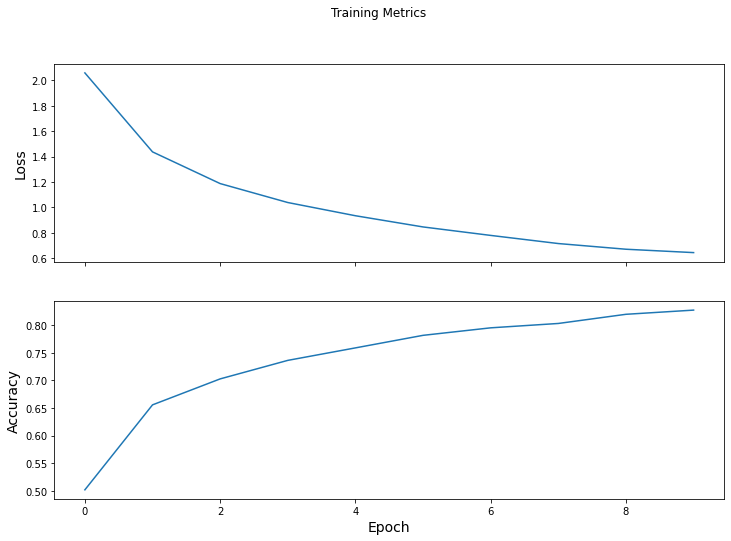

In [77]:
# Plot the training loss and accuracy

fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
fig.suptitle('Training Metrics')

axes[0].set_ylabel("Loss", fontsize=14)
axes[0].plot(train_loss_results)

axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].set_xlabel("Epoch", fontsize=14)
axes[1].plot(train_accuracy_results)
plt.show()

#### Predict from the model

In [78]:
# Get the model prediction for an example input

predicted_label = np.argmax(model(x_train[np.newaxis,0]),axis=1)[0]
print("Prediction: {}".format(class_names[predicted_label]))
print("     Label: {}".format(class_names[train_labels[0]]))

Prediction: earn
     Label: earn


***
<a id="coding_tutorial_5"></a>
## tf.function decorator

In [79]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Softmax
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import reuters
import numpy as np
import matplotlib.pyplot as plt
import time

#### Build the model

In [80]:
# Initialize a new model

model = MyModel(64, 64,46)
print(model(tf.ones((1, 10000))))
model.summary()

tf.Tensor(
[[0.08465429 0.01921886 0.0101821  0.00578364 0.0197926  0.01206647
  0.0151234  0.05755572 0.02871441 0.00846132 0.02334538 0.00652865
  0.03208239 0.00887223 0.0208383  0.00313156 0.00767351 0.01191301
  0.01010692 0.04669331 0.00891499 0.05657095 0.01131112 0.01121197
  0.01465117 0.03458225 0.02240455 0.01006032 0.00903923 0.01286597
  0.00854627 0.01043541 0.00844994 0.02271845 0.01702805 0.01403424
  0.02850006 0.01455238 0.02498098 0.03540456 0.01353837 0.02293482
  0.03428236 0.02597935 0.03827243 0.05599181]], shape=(1, 46), dtype=float32)
Model: "my_model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
my_layer_19 (MyLayer)        multiple                  640064    
_________________________________________________________________
my_dropout_10 (MyDropout)    multiple                  0         
_________________________________________________________________
my_layer_20 (MyLay

#### Redefine the grad function using the @tf.function decorator

In [82]:
# Use the @tf.function decorator

@tf.function
def grad(model, inputs, targets, wd):
    with tf.GradientTape() as tape:
        loss_value = loss(model, inputs, targets, wd)
    return loss_value, tape.gradient(loss_value, model.trainable_variables)

#### Train the model

In [84]:
# Re-run the training loop

from tensorflow.keras.utils import to_categorical

start_time = time.time()

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, train_labels)).batch(32)
train_loss_results = []
train_accuracy_results = []
train_roc_auc_results = []

num_epochs = 10
weight_decay = 0.005

for epoch in range(num_epochs):
    epoch_loss_avg = tf.keras.metrics.Mean()
    epoch_accuracy = tf.keras.metrics.CategoricalAccuracy()
    epoch_roc_auc = tf.keras.metrics.AUC(curve='ROC')
    
    for x, y in train_dataset:
        loss_value, grads = grad(model, x, y, weight_decay)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        
        preds = model(x)
        epoch_loss_avg(loss_value)
        
        print(y.shape)
        print(to_categorical(y, num_classes=46).shape)
        print(preds.shape)        
        epoch_accuracy(to_categorical(y, num_classes=46), preds)     
        epoch_roc_auc(to_categorical(y, num_classes=46), preds) 
        
    train_loss_results.append(epoch_loss_avg.result())
    train_accuracy_results.append(epoch_accuracy.result())
    train_roc_auc_results.append(epoch_roc_auc.result())
    
    print('Epoch {:03d}: Loss: {:0.3f}, Accuracy {:0.3%}, AUC {:0.3%}'.format(epoch, 
                                                                               epoch_loss_avg.result(), 
                                                                               epoch_accuracy.result(),
                                                                               epoch_roc_auc.result()
                                                                              ))
    
    
print("Duration :{:.3f}".format(time.time() - start_time))

(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(

(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(

(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(

(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(

(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(22,)
(22, 46)
(22, 46)
Epoch 004: Loss: 0.553, Accuracy 84.246%, AUC 99.278%
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(

(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(

(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(

(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(

(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46)
(32,)
(32, 46)
(32, 46

如果不加 `@tf.function` 需要70秒左右，增加后，只要51秒左右，性能提升30%左右，不错。

In [336]:
test_accuracy = tf.keras.metrics.CategoricalAccuracy()
test_accuracy(to_categorical(test_labels), model(x_test))
print('With dropout, test accuarcy is', test_accuracy.result().numpy())

test_accuracy = tf.keras.metrics.CategoricalAccuracy()
test_accuracy(to_categorical(test_labels), model(x_test,training=False))
print('Without dropout, test accuarcy is', test_accuracy.result().numpy())

With dropout, test accuarcy is 0.7212823
Without dropout, test accuarcy is 0.7680321


#### Print the autograph code

In [310]:
# Use tf.autograph.to_code to see the generated code


print(tf.autograph.to_code(grad.python_function))

def tf__grad(model, inputs, targets, wd):
    with ag__.FunctionScope('grad', 'fscope', ag__.ConversionOptions(recursive=True, user_requested=True, optional_features=(), internal_convert_user_code=True)) as fscope:
        do_return = False
        retval_ = ag__.UndefinedReturnValue()
        with ag__.ld(tf).GradientTape() as tape:
            loss_value = ag__.converted_call(ag__.ld(loss), (ag__.ld(model), ag__.ld(inputs), ag__.ld(targets), ag__.ld(wd)), None, fscope)
        try:
            do_return = True
            retval_ = (ag__.ld(loss_value), ag__.converted_call(ag__.ld(tape).gradient, (ag__.ld(loss_value), ag__.ld(model).trainable_variables), None, fscope))
        except:
            do_return = False
            raise
        return fscope.ret(retval_, do_return)



In [373]:
from tensorflow.keras.preprocessing.text import Tokenizer

sentences = [
    'i love my dog, i',
    'I, love my cat',
    'You love my dog!'
]

tokenizer = Tokenizer(num_words = 100)
tokenizer.fit_on_texts(sentences)

print('-'*25, '设置', '-'*25)
print('char_level= ', tokenizer.char_level)         # 是否是字符级别
print('lower= ', tokenizer.lower)                   # 大小写
print('oov_token= ', tokenizer.oov_token)           # out of vocabulary的token			
print('num_words= ', tokenizer.num_words)           # 最大word个数

print('-'*25, '具体信息', '-'*25)
print('document_count =', tokenizer.document_count) # 文档数量
print('word_index= ', tokenizer.word_index)         # word:index字典
print('index_word= ', tokenizer.index_word)         # index:word字典
print('word_docs= ', tokenizer.word_docs)           # word在文档出现的次数（同一文档出现多次算一次）
print('index_docs= ', tokenizer.index_docs)         # 同上，只是key是index
print('word_counts= ', tokenizer.word_counts)       # word出现的次数


------------------------- 设置 -------------------------
char_level=  False
lower=  True
oov_token=  None
num_words=  100
------------------------- 具体信息 -------------------------
document_count = 3
word_index=  {'i': 1, 'love': 2, 'my': 3, 'dog': 4, 'cat': 5, 'you': 6}
index_word=  {1: 'i', 2: 'love', 3: 'my', 4: 'dog', 5: 'cat', 6: 'you'}
word_docs=  defaultdict(<class 'int'>, {'dog': 2, 'i': 2, 'my': 3, 'love': 3, 'cat': 1, 'you': 1})
index_docs=  defaultdict(<class 'int'>, {4: 2, 1: 2, 3: 3, 2: 3, 5: 1, 6: 1})
word_counts=  OrderedDict([('i', 3), ('love', 3), ('my', 3), ('dog', 2), ('cat', 1), ('you', 1)])
